# Example of DOPER - Generator Assets

### This examples demonstrates the DOPER framework for genset assets with about 150 kW building base load and 100 kW Photovoltaic (PV) generation.

In [1]:
import os
import sys
import pandas as pd
import matplotlib.pyplot as plt
from pprint import pprint
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
%matplotlib inline

# from IPython.display import HTML
# HTML('''<script>
# code_show=true; 
# function code_toggle() {
#  if (code_show){
#  $('div.input').hide();
#  } else {
#  $('div.input').show();
#  }
#  code_show = !code_show
# } 
# $( document ).ready(code_toggle);
# </script>
# <form action="javascript:code_toggle()">
# <input type="submit" value="Click here to toggle on/off the raw code."></form>
# ''')

### Import DOPER modules

DOPER consists of several modules which are imported here.

New additions:
- dynamic model conversion method to extract data based on which DER assets are enabled
- dynamic plotting that generates plots based on DER options enabled
- genset submodule with related constraints
- example function to add generator to input parameters
- example function to include grid outages to input timeseries data (full offgrid or islanded operation)
- example function to initiate outage in middle of opt horizon (planned or expected outage)

In [2]:
from doper import DOPER, get_solver, get_root, standard_report
from doper.models.basemodel import base_model, default_output_list
from doper.models.genset import add_genset
from doper.examples.example import default_parameter, ts_inputs, parameter_add_genset, ts_inputs_offgrid, ts_inputs_planned_outage
from doper.plotting import plot_dynamic

### Setup Optimization Model

DOPER passes the inputs as first arguments and parameter as second argument to the optimization model (control_model). In this example two models are loaded:
* the "base_model" with energy balance of on-site generation, e.g. Photovoltaic, and demand, e.g. building base laod
* the "add_battery" model which adds individual batteries or electric vehicles, as defined by the input parameters

An objective function is defined as the sum of energy and demand cost, eventual revenue from exporting energy, and from frequency regulation. The weighting between the objectives is again defined within the parameters of the model.

New additions:
- use add_genset func to add genset constraints. identical to previous storage approach
- add fuel costs to objective function formulation

In [3]:
from pyomo.environ import Objective, minimize

def control_model(inputs, parameter):
    model = base_model(inputs, parameter)
    model = add_genset(model, inputs, parameter)
    
    def objective_function(model):
        return model.sum_energy_cost * parameter['objective']['weight_energy'] \
               + model.sum_demand_cost * parameter['objective']['weight_demand'] \
               + model.sum_export_revenue * parameter['objective']['weight_export'] \
               + model.fuel_cost_total * parameter['objective']['weight_energy'] \
               + model.load_shed_cost_total \
               + model.co2_total * parameter['objective']['weight_co2']

    model.objective = Objective(rule=objective_function, sense=minimize, doc='objective function')
    return model

### Load Example Parameter

The "parameter" dictinoary object includes all parameters of the optimization model. The high-level categories are:

* Controller: selection of controller options such as model timestep, optimization horizon, etc.
* Objective: weighting of the multiple objectives
* Site: specifications of the site such as timezone, import and export power limits, customer type, etc.
* Tariff: electricity tariff specified as time-of-use with any number of periods

New additions:
* System: top level options to enable/disable DER and load assets
* Fuels: includes types of fuels available, price, and conversion to kWh equivalent
* Gensets: list of generator objects containing genset properties: capacity, efficiency, etc.

In [4]:
parameter = default_parameter()
parameter = parameter_add_genset(parameter)

print("parameter 'system' object:")
pprint(parameter['system'])
print('')

print("parameter 'fuels' object:")
pprint(parameter['fuels'])
print('')

print("parameter 'gensets' object:")
pprint(parameter['gensets'])
print('')

parameter 'system' object:
{'battery': False,
 'external_gen': False,
 'genset': True,
 'hvac_control': False,
 'load_control': False,
 'pv': True,
 'reg_bidding': False,
 'reg_response': False}

parameter 'fuels' object:
[{'co2': 5.3,
  'conversion': 30.77,
  'name': 'ng',
  'rate': 3.93,
  'reserves': 0,
  'unit': 'therms'},
 {'co2': 10.18,
  'conversion': 35.75,
  'name': 'diesel',
  'rate': 3.4,
  'reserves': 100,
  'unit': 'gallons'}]

parameter 'gensets' object:
[{'backupOnly': True,
  'capacity': 60,
  'efficiency': 0.25,
  'fuel': 'ng',
  'maxRampDown': 0.5,
  'maxRampUp': 0.5,
  'name': 'genset_1',
  'omVar': 0.01,
  'regulation': False,
  'timeToStart': 1},
 {'backupOnly': True,
  'capacity': 80,
  'efficiency': 0.3,
  'fuel': 'diesel',
  'maxRampDown': 0.5,
  'maxRampUp': 0.5,
  'name': 'genset_2',
  'omVar': 0.01,
  'regulation': False,
  'timeToStart': 1}]



### Load Example Data

The input data in this example is chosen to represent a medium-sized office building with rooftop photovoltaic system and three electric vehicles.

New additions:
- 'grid_available' field to indicate availability of grid connection

In [5]:
data = ts_inputs(parameter, load='B90', scale_load=150, scale_pv=100)
# offgrid_data = ts_inputs_offgrid(parameter)

### Conduct Optimization

In order to conduct the optimization, the DOPER object is initialized with the model, parameter, and the pyomo_to_pandas converter function. In the next step, the model is evaluated with the "do_optimization" class function. It takes the current inputs as input and returns a list of results.

Note that DOPER is built for application as Model Predictive Control (MPC) where the optimization model is periodically, e.g. every five minutes, updated with the most recent inputs, and reevaluated. However, in this example, do_optimization is only executed once.

In [10]:
# update generators to be available while grid-connected
parameter['gensets'][0]['backupOnly'] = False
parameter['gensets'][1]['backupOnly'] = False

# Define the path to the solver executable
solver_path = get_solver('cbc', solver_dir=os.path.join(get_root(), 'solvers'))
print(solver_path)
# Initialize DOPER
smartDER = DOPER(model=control_model,
                 parameter=parameter,
                 solver_path=solver_path)

# Conduct optimization
res = smartDER.do_optimization(data)

# Get results
duration, objective, df, model, result, termination, parameter = res
print(standard_report(res))

C:\Users\nicholas\.conda\envs\doperDev\lib\site-packages\doper\solvers\Windows64\cbc.exe
Solver			CBC 2.10.3
Duration [s]		3.6
Objective [$]		684.79			0.0 (Total Cost)
Cost [$]		0.0 (Energy)	0.0 (Demand)
CO2 Emissions [kg]		1991.51



### Result for Site

New additions:
- changes to plotting functions to show energy consumption and provision by source
- dynamic plotting functions should add or remove relevant plots based on parameter system options

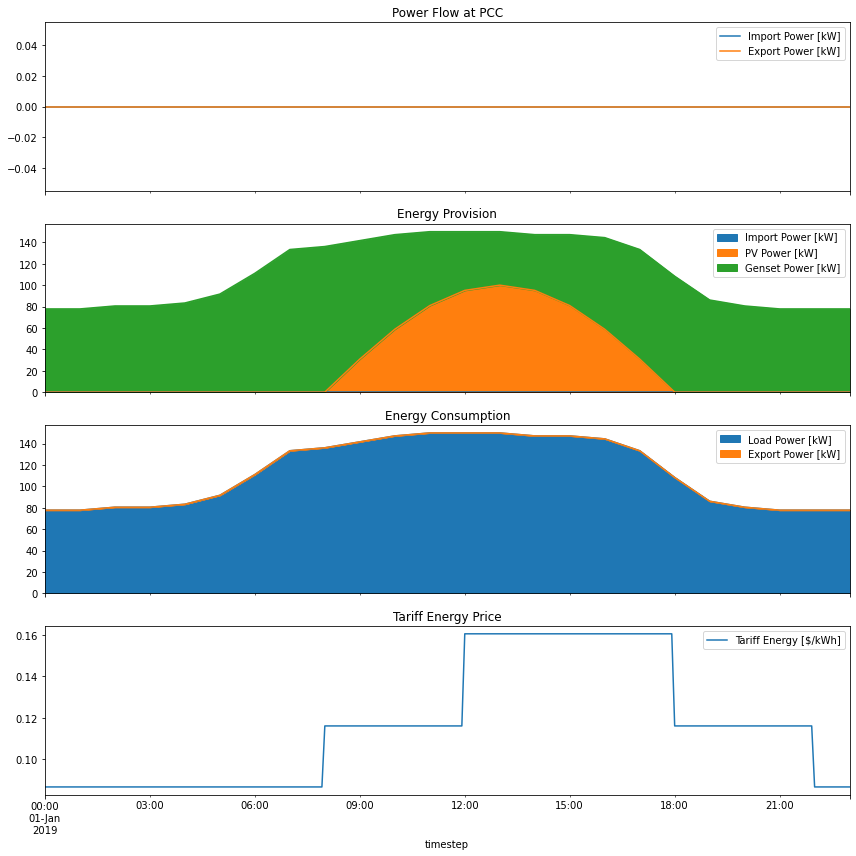

In [11]:
plotData = plot_dynamic(df, parameter, plotFile = None, plot_reg=False)

### Back-up Only Functionality

In [8]:
# update generators to run as back-up only
parameter['gensets'][0]['backupOnly'] = True
parameter['gensets'][1]['backupOnly'] = True
# increase capacity to weather outage                     
parameter['gensets'][0]['capacity'] = 60
parameter['gensets'][1]['capacity'] = 100

# generate timeseries data with planned outage
data = ts_inputs_planned_outage(parameter)

# Initialize DOPER
smartDER = DOPER(model=control_model,
                 parameter=parameter,
                 solver_path=solver_path)

# Conduct optimization
res = smartDER.do_optimization(data)

# Get results
duration, objective, df, model, result, termination, parameter = res
print(standard_report(res))

Solver			CBC 2.10.3
Duration [s]		3.53
Objective [$]		3558.29			3255.57 (Total Cost)
Cost [$]		105.96 (Energy)	3149.61 (Demand)
CO2 Emissions [kg]		3582.05



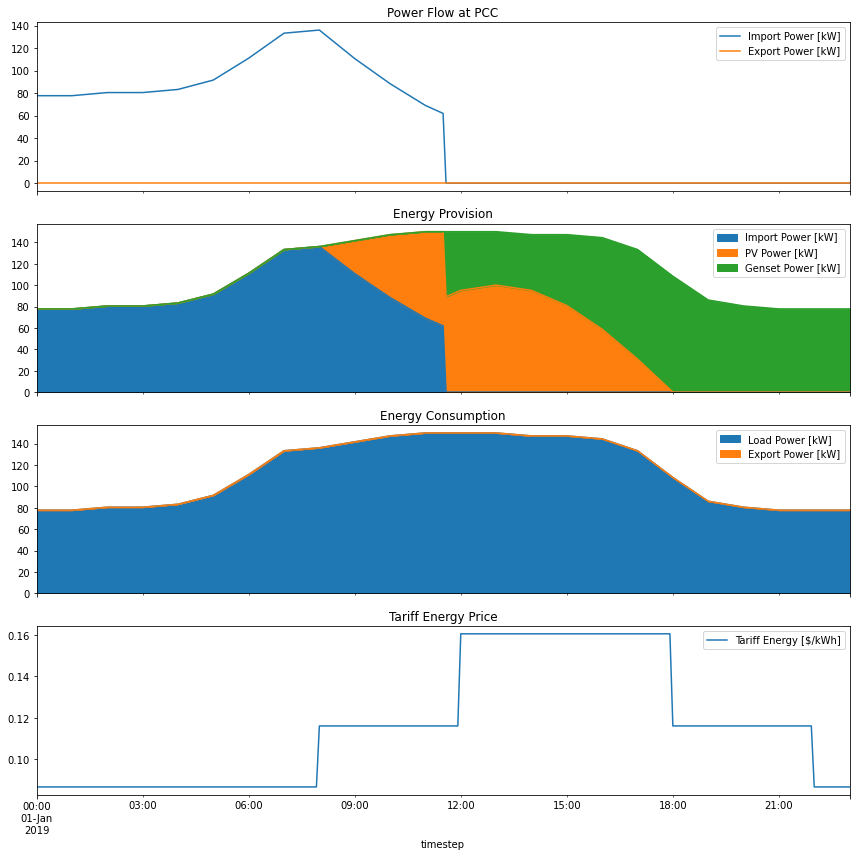

In [9]:
plotData = plot_dynamic(df, parameter, plotFile = None, plot_reg=False)

### Development to-do list

- complete genset ramp rate constraints
- add genset capacity to regulation if enabled
- add timeseries reporting for individual genset set-points